In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In [53]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import tensorflow as tf
import keras
from keras import models
from tensorflow.python.keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

from keras.layers import Bidirectional #we will be needing this layer
from sklearn.model_selection import StratifiedKFold
import time
import gc
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import lineplot
import plotly.graph_objects as go

In [108]:
import numpy as np
import os

class DataLoader:
    def __init__(self):
        pass

    def npz_load(self, npzfile):
        try:
            with np.load(npzfile) as file:
                data = file['x']
                labels = file['y']
                sampling_rate = file['fs']
            return data, labels, sampling_rate
        except Exception as e:
            print(f"Error loading {npzfile}: {e}")
            return None, None, None

    def load_n_npzfiles(self, npzfiles):
        data = []
        labels = []
        fs = None
        for npz_file in npzfiles:
            t_data, t_labels, sampling_rate = self.npz_load(npz_file)
            if t_data is None:
                continue  # Skip to the next file if loading failed
            if fs is None:
                fs = sampling_rate
            elif fs != sampling_rate:
                raise Exception("Mismatch in Sampling Rate")
            data.append(t_data)
            labels.append(t_labels)
        if len(data) == 0 or len(labels) == 0:
            print("No valid data loaded.")
            return None, None
        data = np.vstack(data)
        labels = np.hstack(labels)
        return data, labels

    def load_data(self,path_):
        files = os.listdir(path_)
        if len(files) <= 9:
            print("Error: Not enough files in the directory.")
            return None, None
        fs = [os.path.join(path_, i) for i in files]
        X, Y = self.load_n_npzfiles(fs[:-9])
        if X is None or Y is None:
            print("Error: Failed to load data.")
            return None, None
        print(X.shape)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        return X, Y

    def load_test_data(self,path):
      files = os.listdir(path)
      fs = [os.path.join(path, i) for i in files]
      X, Y = self.load_n_npzfiles(fs)
      if X is None or Y is None:
            print("Error: Failed to load data.")
            return None, None
      print(X.shape)
      X = X.reshape((X.shape[0], X.shape[1], 1))

      return X, Y


In [109]:
data_loader = DataLoader()

# Load and reshape the data
X, Y = data_loader.load_data("/content/drive/MyDrive/project/DATA")
X = X[:15000]
Y = Y [:15000]

print(X.shape)

(56912, 3000, 1)
(15000, 3000, 1)


0

In [87]:
class MyModel:


    def __init__(self, nsplits=5):
        self.nsplits = nsplits
        self.cv_results = []
        self.onlycnn = models.load_model('/content/drive/MyDrive/project/CNN.h5')
        self.cnnlstm = models.load_model('/content/drive/MyDrive/project/CNNLSTM.h5')
        self.lstm = models.load_model('/content/drive/MyDrive/project/LSTM.h5')

    def compare(self, y_prob, y_prob1):
        actual_pred = []
        for i in range(len(y_prob1)):
            l = []
            for j in range(5):
                l.append((y_prob[i][j] + y_prob1[i][j]) / 2)
            maxval = max(l)
            idx = l.index(maxval)
            actual_pred.append(idx)
        return actual_pred

    def train_and_evaluate(self, X, Y):
        sk = StratifiedKFold(n_splits=self.nsplits)
        k = 0
        for train_idx, test_idx in sk.split(X, Y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = Y[train_idx], Y[test_idx]
            X_c_train, X_c_test = X_train, X_test
            y_c_train, y_c_test = y_train, y_test
            X_train = np.reshape(X_train, (-1, X_train.shape[1], 1))
            X_test = np.reshape(X_test, (-1, X_test.shape[1], 1))
            # Applying standardization
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train.reshape((X_train.shape[0], -1))).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape((X_test.shape[0], -1))).reshape(X_test.shape)
            # Assuming onlycnn, cnnlstm, lstm are defined somewhere
            self.onlycnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
            # Training the model
            history = self.onlycnn.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

            self.cnnlstm.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                            optimizer=keras.optimizers.Adam(learning_rate=0.001),
                            metrics=['accuracy'])
            self.cnnlstm.fit(X_c_train, y_c_train,batch_size=100,epochs=5)  # 24

            # getting feature vectors
            layer_name = 'concat'
            intermediate_layer_model = keras.Model(inputs=self.cnnlstm.input,
                                                    outputs=self.cnnlstm.get_layer(layer_name).output)
            intermediate_output_train = intermediate_layer_model.predict(X_c_train)
            intermediate_output_test = intermediate_layer_model.predict(X_c_test)
            X_train_lstm = intermediate_output_train
            X_test_lstm = intermediate_output_test
            a = np.zeros((1, 2688))
            X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
            X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
            X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)
            X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)
            X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
            X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
            X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)
            X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)
            num_train_clips = len(X_train_lstm) - 4
            num_test_clips = len(X_test_lstm) - 4
            clip_length = 2688
            X_train_lstm2 = np.empty((num_train_clips, 5, clip_length))  # Initialize empty array for training clips
            for i in range(num_train_clips):
                j = i + 2
                X_train_lstm2[i] = np.array(
                    [X_train_lstm[j - 2], X_train_lstm[j - 1], X_train_lstm[j], X_train_lstm[j + 1], X_train_lstm[j + 2]])

            X_test_lstm2 = np.empty((num_test_clips, 5, clip_length))  # Initialize empty array for testing clips
            for i in range(num_test_clips):
                j = i + 2
                X_test_lstm2[i] = np.array(
                    [X_test_lstm[j - 2], X_test_lstm[j - 1], X_test_lstm[j], X_test_lstm[j + 1], X_test_lstm[j + 2]])


            # LSTM
            self.lstm.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                         optimizer=keras.optimizers.Adam(learning_rate=0.001),
                         metrics=['accuracy'])
            self.lstm.fit(X_train_lstm2, y_c_train,
                     batch_size=100,
                     epochs=5, validation_data=(X_test_lstm2, y_test))  #

            # Evaluate

            # only CNN
            y_probcnn = self.onlycnn.predict(X_test)
            y_pred1 = y_probcnn.argmax(axis=-1)
            loss, accuracy = self.onlycnn.evaluate(X_test, y_test)
            print(f'Test Loss: {loss:.4f}')
            print(f'Test Accuracy: {accuracy:.4f}')
            begin_time_loop = dt.now()
            print('Current time: {}'.format(str(begin_time_loop)))

            # LSTM
            y_prob = self.lstm.predict(X_test_lstm2)  ##
            y_pred = y_prob.argmax(axis=-1)
            elapsed = dt.now() - begin_time_loop

            # Final Predict
            final_pred = self.compare(y_probcnn, y_prob)
            print('Fold {} took {}'.format(str(k), str(elapsed)))
            fold_result = {'fold': k, 'time': elapsed, 'y_test': y_test, 'y_pred': final_pred, 'y_cnn': y_pred1,
                           'y_lstm': y_pred, 'y_prob': y_prob,
                           'Final_accuracy': accuracy_score(final_pred, y_test),
                           'cnn_accuracy': accuracy, 'lstm_accuracy': test_scores[1]}
            del X_test_lstm2, X_train_lstm2, intermediate_output_train, intermediate_output_test
            gc.collect()
            k += 1
            print("Final prediction:", accuracy_score(final_pred, y_test))
            self.cv_results.append(fold_result)


    def predict(self, new_data):
        # Assuming onlycnn, cnnlstm, and lstm are defined somewhere
        # Preprocess the new data
        new_data = np.reshape(new_data, (-1, new_data.shape[1], 1))
        scaler = StandardScaler()
        new_data = scaler.fit_transform(new_data.reshape((new_data.shape[0], -1))).reshape(new_data.shape)

        # Predict using onlycnn
        y_prob_cnn = self.onlycnn.predict(new_data)
        y_pred_cnn = y_prob_cnn.argmax(axis=-1)

        # # Get feature vectors using cnnlstm
        # intermediate_layer_model = keras.Model(inputs=self.cnnlstm.input,
        #                                         outputs=self.cnnlstm.get_layer('concat').output)
        # intermediate_output = intermediate_layer_model.predict(new_data)

        # # Reshape and process feature vectors for lstm
        # X_lstm = np.empty((len(intermediate_output), 5, 2688))
        # for i in range(len(intermediate_output)):
        #   for j in range(2, len(intermediate_output[i]) - 2):
        #     X_lstm[i, j - 2] = np.array([intermediate_output[i][j - 2], intermediate_output[i][j - 1],
        #                               intermediate_output[i][j], intermediate_output[i][j + 1],
        #                               intermediate_output[i][j + 2]])


        # Predict using lstm
        # y_prob_lstm = self.lstm.predict(X_lstm)
        # y_pred_lstm = y_prob_lstm.argmax(axis=-1)

        # Final prediction
        # final_pred = self.compare(y_pred_cnn, y_pred_lstm)  # You need to implement compare function

        return y_pred_cnn


    def hypnogram(self,y_pred):

      plt.figure(figsize=(14, 4))
      plt.title('Hypnogram', size=14)
      plt.xlabel('Time (in 30 second epochs)', fontsize=14)
      plt.ylabel('Sleep stage', fontsize=14)

      # Assigning numeric values to sleep stages
      sleep_stages = ['Wake', 'REM', 'Stage 1 (N1)', 'Stage 2 (N2)', 'Stage 3 (N3)']
      sleep_stage_values = [0, 1, 2, 3, 4]

      # Plotting using numeric values for y-axis
      sns.lineplot(data=y_pred, dashes=False, palette="tab10", linewidth=1.5)

      # Formatting y-axis ticks to display sleep stage labels
      plt.yticks(sleep_stage_values, sleep_stages)

      plt.legend(labels=['Sleep Stage'])
      plt.show()

    def calculate_class_percentage(self,samples):

      class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
      total_samples = len(samples)

      # Count occurrences of each class label
      for label in samples:
          class_counts[label] += 1

      # Calculate percentage for each class label
      class_percentages = {}
      for label, count in class_counts.items():
          percentage = (count / total_samples) * 100
          class_percentages[label] = percentage

      return class_percentages

    def plot_pie_chart(self,class_percentages):
      labels = ['Wake', 'REM', 'Stage 1 (N1)', 'Stage 2 (N2)', 'Stage 3 (N3)']
      sizes = [class_percentages[label] for label in range(5)]
      colors = ['#9400D3', '#7B68EE', '#8A2BE2', '#4B0082', '#483D8B']

      fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, hole=0.3,
                                  marker=dict(colors=colors, line=dict(color='#000000', width=2)),
                                  textinfo='label+percent',
                                  textfont=dict(color='white', size=14))])

      fig.update_layout(
          showlegend=False,
          legend=dict(
              x=1,
              y=1,
              traceorder='normal',
              font=dict(
                  family='sans-serif',
                  size=12,
                  color='#000'
              ),
              bgcolor='#E2E2E2',
              bordercolor='#FFFFFF',
              borderwidth=2
          ),
          paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
      )

      fig.show()





In [88]:
model = MyModel()

In [ ]:
model.train_and_evaluate(X,Y)

In [99]:
data_loader = DataLoader()




In [117]:
# Load and reshape the data
X, Y = data_loader.load_test_data("/content/drive/MyDrive/project/Test Data")

(1003, 3000, 1)


In [94]:
print(X.shape)
print(Y.shape)


(928, 3000, 1)
(928,)


In [74]:
y_pred = model.predict(X)

29/29 [==============================] - 7s 224ms/step


In [118]:
print(Y.tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 

In [ ]:
y_pred

<ipython-input-77-b02aee34a0f4>:164: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



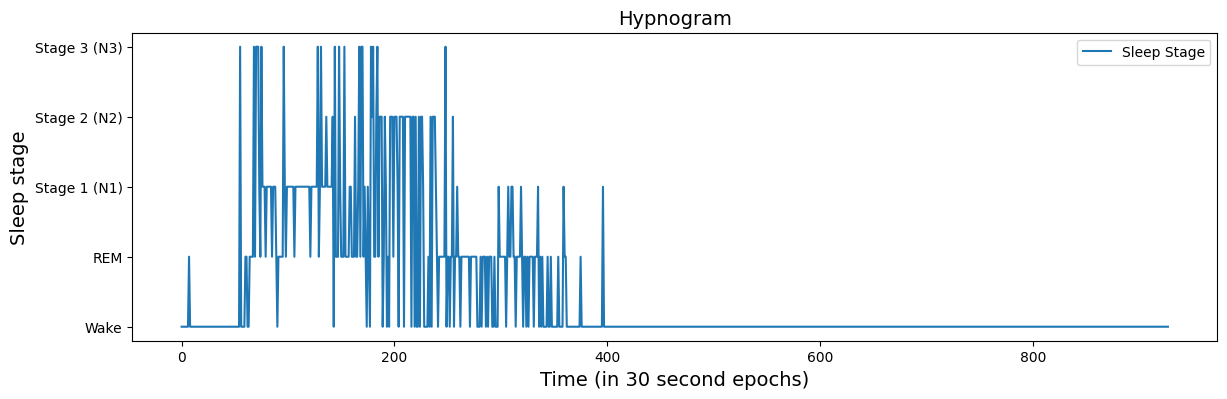

In [79]:
model.hypnogram(y_pred)

In [75]:
per = model.calculate_class_percentage(y_pred)

In [89]:
model.plot_pie_chart(per)

In [98]:
import pickle

# Create an instance of MyModel
my_model = MyModel()

# Pickle the instance and save it to a file
with open('my_model.pkl', 'wb') as f:
    pickle.dump(my_model, f)


In [101]:
# Create an instance of MyModel
data_loader = DataLoader()

# Pickle the instance and save it to a file
with open('data_loader.pkl', 'wb') as f:
    pickle.dump(data_loader, f)